# Import packages and load data


In [9]:
# Import packages and load data
import pandas as pd
from carbon_bombs.io.rystad import load_rystad_cb_emission_database
from carbon_bombs.conf import FPATH_OUT_CB

# Carbon Bombs v2
cb_v2 = load_rystad_cb_emission_database()

# Carbon Bombs v1
cb_v1 = pd.read_csv(FPATH_OUT_CB)
cb_v1 = cb_v1.loc[cb_v1.Fuel_type_source_CB == 'Oil&Gas']

# Cleaning actions


In [10]:
# Clean country names between versions
cb_v1["Country_source_CB"] = cb_v1["Country_source_CB"].replace("United Arab Emirates", "UAE")

# Define manual matching

In [11]:
# Define manual matching dictionary
manual_matching = {
    "Tarim (CNPC)": "Tarim",
    "Xinjiang (CNPC)": "Xinjiang",
    "Ahwaz Asmari":"Ahwaz (Ahwaz Asmari)",
    "Ahwaz Bangestan":"Ahwaz (Bangestan)",
    "Austin Chalk Tight":"Austin Chalk Horizontal",
    "Greater Burgan": "Greater Burgan (CR in field)",
    "Hassi R'Mel (Domestic)": "Hassi R'Mel (Pipe Export)",
    "West Siberia Onshore" : "Lukoil-West Siberia",
    "South Pars (Phases 4-5) dry gas": "South Pars (Phases 4-5)",
    "South Pars (Phases 22-24)":"South Pars (Phases 23-28)",
    # 2 project can be match for Yamal in v1 : Bovanenkovo Zone or Tambei Zone, we keep the southern zone
    "Bovanenkovo Zone (Yamal Megaproject)" : "Southern Zone (Yamal Megaproject)",
    "Greater Turbot (Stabroek)" : "Stabroek Future Phases",
    # Only one project in tanzania for both version, we decide to match them manually
    "Tanzanian Coastal Offshore":"Tanzania LNG (Block 1/4 and 2)",
    "Lula (X-Tupi)":"Tupi (x-Lula)",
    "Haynesville/Bossier Shale":"Western Haynesville/Bossier Shale",
    "Longmaxi Shale (Sichuan/Changyu)": "Yaan Slope Onshore Sichuan Province",
}

# Process datasets and match carbon bombs projects between versions / Create a comparison dataframe

In [12]:
from carbon_bombs.utils.logger import LOGGER

# First, create two dataframes with only the columns we want and rename them
df_v1 = cb_v1[['Carbon_bomb_name_source_CB', 'Country_source_CB', 'Potential_GtCO2_source_CB', 'Latitude', 'Longitude']].copy()
df_v2 = cb_v2[['Project_name', 'Country', 'Total_potential_emissions_in_GTCO2', 'Latitude', 'Longitude']].copy()

# Rename columns
df_v1 = df_v1.rename(columns={
    'Carbon_bomb_name_source_CB': 'project_name_v1',
    'Country_source_CB': 'country_v1',
    'Potential_GtCO2_source_CB': 'emissions_v1',
    'Latitude': 'latitude_v1',
    'Longitude': 'longitude_v1',
})

df_v2 = df_v2.rename(columns={
    'Project_name': 'project_name_v2',
    'Country': 'country_v2',
    'Total_potential_emissions_in_GTCO2': 'emissions_v2',
    'Latitude': 'latitude_v2',
    'Longitude': 'longitude_v2'
})

# Remove trailing and leading spaces from project names
df_v1['project_name_v1'] = df_v1['project_name_v1'].str.strip()
df_v2['project_name_v2'] = df_v2['project_name_v2'].str.strip()

# Create a mapping series for manual matches
manual_mapping = pd.Series(manual_matching)

# Apply manual matching to project names while keeping the original country
df_v1['matching_name'] = df_v1['project_name_v1'].map(manual_matching).fillna(df_v1['project_name_v1']).str.lower()
df_v2['matching_name'] = df_v2['project_name_v2'].str.lower()

# Create composite keys combining project name and country
df_v1['matching_key'] = df_v1['matching_name'] + '|' + df_v1['country_v1'].str.lower()
df_v2['matching_key'] = df_v2['matching_name'] + '|' + df_v2['country_v2'].str.lower()

# Perform outer join using the composite key
comparison_df = df_v1.merge(
    df_v2,
    on='matching_key',
    how='outer',
    indicator=True
)

# Check for country mismatches
country_mismatches = []
for idx, row in comparison_df.iterrows():
    if pd.notna(row['country_v1']) and pd.notna(row['country_v2']) and row['country_v1'] != row['country_v2']:
        LOGGER.warning(f"Country mismatch for project '{row['project_name_v1']}' -> '{row['project_name_v2']}': "
                      f"V1: {row['country_v1']} vs V2: {row['country_v2']}")
        country_mismatches.append({
            'project': row['project_name_v1'],
            'project_v2': row['project_name_v2'],
            'country_v1': row['country_v1'],
            'country_v2': row['country_v2']
        })

# Clean up the DataFrame
comparison_df = comparison_df.drop(['matching_name_x', 'matching_name_y'], axis=1, errors='ignore')

# Print manual matches that were successful
successful_manual_matches = comparison_df[
    comparison_df['project_name_v1'].isin(manual_matching.keys()) & 
    (comparison_df['_merge'] == 'both')
]
if not successful_manual_matches.empty:
    print("\nSuccessful manual matches:")
    for _, row in successful_manual_matches.iterrows():
        print(f"V1: '{row['project_name_v1']}' -> V2: '{row['project_name_v2']}'")

""" TO DELETE
# Print country mismatches if any
if country_mismatches:
    print("\nDetailed country mismatches:")
    for mismatch in country_mismatches:
        print(f"Project: {mismatch['project']} -> {mismatch['project_v2']}")
        print(f"  V1 country: {mismatch['country_v1']}")
        print(f"  V2 country: {mismatch['country_v2']}")
"""


Successful manual matches:
V1: 'Ahwaz Asmari' -> V2: 'Ahwaz (Ahwaz Asmari)'
V1: 'Ahwaz Bangestan' -> V2: 'Ahwaz (Bangestan)'
V1: 'Austin Chalk Tight' -> V2: 'Austin Chalk Horizontal'
V1: 'Greater Burgan' -> V2: 'Greater Burgan (CR in field)'
V1: 'Hassi R'Mel (Domestic)' -> V2: 'Hassi R'Mel (Pipe Export)'
V1: 'West Siberia Onshore' -> V2: 'Lukoil-West Siberia'
V1: 'South Pars (Phases 22-24)' -> V2: 'South Pars (Phases 23-28)'
V1: 'South Pars (Phases 4-5) dry gas' -> V2: 'South Pars (Phases 4-5)'
V1: 'Bovanenkovo Zone (Yamal Megaproject)' -> V2: 'Southern Zone (Yamal Megaproject)'
V1: 'Greater Turbot (Stabroek)' -> V2: 'Stabroek Future Phases'
V1: 'Tanzanian Coastal Offshore' -> V2: 'Tanzania LNG (Block 1/4 and 2)'
V1: 'Tarim (CNPC)' -> V2: 'Tarim'
V1: 'Lula (X-Tupi)' -> V2: 'Tupi (x-Lula)'
V1: 'Haynesville/Bossier Shale' -> V2: 'Western Haynesville/Bossier Shale'
V1: 'Xinjiang (CNPC)' -> V2: 'Xinjiang'
V1: 'Longmaxi Shale (Sichuan/Changyu)' -> V2: 'Yaan Slope Onshore Sichuan Province'


' TO DELETE\n# Print country mismatches if any\nif country_mismatches:\n    print("\nDetailed country mismatches:")\n    for mismatch in country_mismatches:\n        print(f"Project: {mismatch[\'project\']} -> {mismatch[\'project_v2\']}")\n        print(f"  V1 country: {mismatch[\'country_v1\']}")\n        print(f"  V2 country: {mismatch[\'country_v2\']}")\n'

# Summary informations 


In [13]:
# Print summary
print(f"\nSummary:")
print(f"Total projects in v1: {len(df_v1)}")
print(f"Total projects in v2: {len(df_v2)}")
print(f"Matched projects: {len(comparison_df[comparison_df['_merge'] == 'both'])}")
print(f"Projects only in v1: {len(comparison_df[comparison_df['_merge'] == 'left_only'])}")
print(f"Projects only in v2: {len(comparison_df[comparison_df['_merge'] == 'right_only'])}")
print(f"Number of country mismatches: {len(country_mismatches)}")

# Print projects only in V2
v2_only = comparison_df[comparison_df['_merge'] == 'right_only']
if not v2_only.empty:
    print("\nProjects only in V2:")
    for _, row in v2_only.iterrows():
        print(f"- {row['project_name_v2']} ({row['country_v2']})")

        # TODO add possible matching recomendation


Summary:
Total projects in v1: 195
Total projects in v2: 196
Matched projects: 141
Projects only in v1: 54
Projects only in v2: 55
Number of country mismatches: 0

Projects only in V2:
- ADNOC Sole Risk (UAE)
- Alaska LNG (United States)
- Area 1 LNG (T3-T4) (Mozambique)
- Bovanenkovo Zone (Yamal Megaproject) (Russia)
- Cambay Shale (India)
- Cardium Play (Canada)
- Fadhili Gas Project (Saudi Arabia)
- Forouzan (Iran)
- Gazprom Dobycha Noyabrsk (Russia)
- Gazpromneft-Khantos (Russia)
- Gazpromneft-NNG (Russia)
- Gazpromneft-Zapolyarye (Russia)
- Golshan (Iran)
- Greater Burgan (Kuwait)
- Greater Green River Tight Gas (United States)
- Gumai Formation (Indonesia)
- Hassi R'Mel (Domestic) (Algeria)
- Haynesville/Bossier Shale (United States)
- Iara (Brazil)
- Jafurah shale gas (Al Hasa) (Saudi Arabia)
- Kirkuk (Iraq)
- Longmaxi Shale (Xi'nan-CNPC) (China)
- Maykop Shale (Azerbaijan)
- North Pars LNG (Iran)
- North West Shelf LNG (Australia)
- Ordos Basin CBM (China)
- Ordovician Shale (

# Calculate difference between versions (Potential emissions and coordinates)

In [14]:
from geopy.distance import geodesic

# Calculate distance between coordinates using geopy
def calculate_distance(row):
    """Calculate the distance between two points in kilometers using geopy"""
    if pd.isna(row['latitude_v1']) or pd.isna(row['longitude_v1']) or pd.isna(row['latitude_v2']) or pd.isna(row['longitude_v2']):
        return None
    
    coords_1 = (row['latitude_v1'], row['longitude_v1'])
    coords_2 = (row['latitude_v2'], row['longitude_v2'])
    
    return geodesic(coords_1, coords_2).kilometers

# Calculate emissions difference (V2 - V1)
comparison_df['emissions_difference'] = comparison_df['emissions_v2'] - comparison_df['emissions_v1']

# Add percentage difference for emissions
comparison_df['emissions_pct_difference'] = (
    (comparison_df['emissions_v2'] - comparison_df['emissions_v1']) / 
    comparison_df['emissions_v1'] * 100
).round(2)

# Calculate distance difference (V2 - V1)
comparison_df['distance_km'] = comparison_df.apply(calculate_distance, axis=1)

# Print summary of differences
print("\nEmissions and Location Differences Summary:")
matched_projects = comparison_df[comparison_df['project_name_v2'].notna()]

print(f"\nEmissions differences (for matched projects):")
print(f"Mean absolute difference: {matched_projects['emissions_difference'].abs().mean():.2f} GTCO2")
print(f"Max absolute difference: {matched_projects['emissions_difference'].abs().max():.2f} GTCO2")

# Projects with significant emissions differences
projects_big_emission_diff = matched_projects[matched_projects['emissions_pct_difference'].abs() > 10]
print(f"Projects with >10% difference: {len(projects_big_emission_diff)}")
if not projects_big_emission_diff.empty:
    print("Projects:")
    for _, row in projects_big_emission_diff.iterrows():
        print(f"- {row['project_name_v1']}: {row['emissions_pct_difference']:.1f}% difference "
              f"({row['emissions_v1']:.2f} -> {row['emissions_v2']:.2f} GTCO2)")

print(f"\nLocation differences (for matched projects):")
print(f"Mean distance between points: {matched_projects['distance_km'].mean():.2f} km")
print(f"Max distance between points: {matched_projects['distance_km'].max():.2f} km")

# Projects with significant location differences
projects_big_location_diff = matched_projects[matched_projects['distance_km'] > 10]
print(f"Projects with >10km difference: {len(projects_big_location_diff)}")
if not projects_big_location_diff.empty:
    print("Projects:")
    for _, row in projects_big_location_diff.iterrows():
        print(f"- {row['project_name_v1']}: {row['distance_km']:.1f} km difference")
        print(f"  V1 coordinates: ({row['latitude_v1']:.4f}, {row['longitude_v1']:.4f})")
        print(f"  V2 coordinates: ({row['latitude_v2']:.4f}, {row['longitude_v2']:.4f})")



Emissions and Location Differences Summary:

Emissions differences (for matched projects):
Mean absolute difference: 1.09 GTCO2
Max absolute difference: 11.45 GTCO2
Projects with >10% difference: 97
Projects:
- Abqaiq: 72.2% difference (1.59 -> 2.74 GTCO2)
- ACG (Azeri-Chirag-Guneshli Deep Water): -38.3% difference (1.66 -> 1.02 GTCO2)
- Agha Jari: 28.5% difference (1.56 -> 2.01 GTCO2)
- Ahwaz Asmari: -28.1% difference (2.24 -> 1.61 GTCO2)
- Ahwaz Bangestan: 14.3% difference (1.43 -> 1.64 GTCO2)
- Al Khaleej Gas project: -13.2% difference (1.14 -> 0.99 GTCO2)
- Asab: 25.8% difference (1.37 -> 1.73 GTCO2)
- Athabasca Oil Sands Project: -20.7% difference (1.36 -> 1.08 GTCO2)
- Austin Chalk Tight: 75.2% difference (1.39 -> 2.44 GTCO2)
- Bab: -21.5% difference (4.20 -> 3.29 GTCO2)
- Barnett Shale: -17.6% difference (1.36 -> 1.12 GTCO2)
- Basrah Gas project: -16.9% difference (1.04 -> 0.87 GTCO2)
- Bowland Shale: -43.3% difference (1.48 -> 0.84 GTCO2)
- Buzios (x-Franco): -19.0% difference

# Clean dataframe and save result 

In [15]:
# Clean up final DataFrame
comparison_df = comparison_df.drop('_merge', axis=1)

# Sort the DataFrame to group matched and unmatched projects
comparison_df = comparison_df.sort_values(
    by=['project_name_v1', 'project_name_v2'],
    na_position='last'
)

# Reorder columns
ordered_columns = [
    'project_name_v1',
    'project_name_v2',
    'country_v1',
    'country_v2',
    'emissions_v1',
    'emissions_v2',
    'emissions_difference',
    'emissions_pct_difference',
    'latitude_v1',
    'longitude_v1',
    'latitude_v2',
    'longitude_v2',
    'distance_km',
    'matching_key'
]

# Reorder columns and save to CSV
comparison_df = comparison_df[ordered_columns]

# Save to CSV
comparison_df.to_csv('carbon_bombs_comparison.csv', index=False, sep=';')

# Graphs


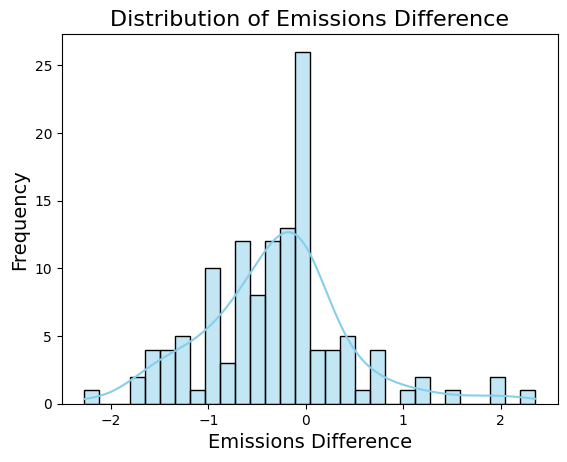

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Only keep matched projects (those with rows'project_name_v1' and 'project_name_v2' columns not empty)
filtered_df = comparison_df[comparison_df['project_name_v1'].notna() & comparison_df['project_name_v2'].notna()]
# filtered_df = filtered_df[
#     (filtered_df['emissions_difference'] >= -2.5) & 
#     (filtered_df['emissions_difference'] <= 2.5)
# ]


# Create the histogram
sns.histplot(filtered_df['emissions_difference'].dropna(), bins=30, kde=True, color='skyblue')

# Add titles and labels
plt.title('Distribution of Emissions Difference', fontsize=16)
plt.xlabel('Emissions Difference', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.show()